# Comparison and Analysis of Fairness metrics for FairDedup with different clustering methods.

## Loading prediction results of different models


In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

original_model_predictions = pickle.load(open('oroginal_model_prediction.pkl', 'rb'))
faiss_dedup_model_prediction = pickle.load(open('faiss_dedup_model_prediction.pkl', 'rb'))
kmeans_1000_dedup_model_prediction = pickle.load(open('kmeans_1000_dedup_model_prediction.pkl', 'rb'))
kmeans_500_dedup_model_prediction = pickle.load(open('kmeans_500_dedup_model_prediction.pkl', 'rb'))
kmeans_1500_dedup_model_prediction = pickle.load(open('kmeans_1500_dedup_model_prediction.pkl', 'rb'))
minibatch_dedup_model_prediction = pickle.load(open('minibatch_dedup_model_prediction (1).pkl', 'rb'))
true_labels = pickle.load(open('test_true_labels.pkl', 'rb'))

## Calclulate FPRs and TPRs

In [3]:
def calculate_tpr(df, predicted_label, true_label):
  TP = ((df[true_label] == 1) & (df[predicted_label] == 1)).sum()
  FN = ((df[true_label] == 1) & (df[predicted_label] == 0)).sum()
  return TP / (TP + FN)

def calculate_fpr(df, predicted_label, true_label):
  FP = ((df[true_label] == 0) & (df[predicted_label] == 1)).sum()
  TN = ((df[true_label] == 0) & (df[predicted_label] == 0)).sum()
  return FP / (FP + TN)

In [4]:
def calcluate_overall_tpr(df_disease, labels, pred_prefix):
  TPR_per_disease = {}
  for disease in labels:
    predicted_disease_name = pred_prefix + str(disease)
    TPR = calculate_tpr(df_disease, predicted_disease_name, disease)
    TPR_per_disease[disease] = TPR
  return TPR_per_disease


def calcluate_overall_fpr(df_disease, labels, pred_prefix):
  FPR_per_disease = {}
  for disease in labels:
    predicted_disease_name = pred_prefix + str(disease)
    FPR = calculate_fpr(df_disease, predicted_disease_name, disease)
    FPR_per_disease[disease] = FPR
  return FPR_per_disease

In [5]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']

pred_prefix = 'predictions_'


In [6]:
def calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, subgroup):
    subgroup_groups = df_disease[subgroup].unique()
    FPR_per_subgroup = {}
    for sub in subgroup_groups:
        df_subgroup = df_disease[df_disease[subgroup] == sub]
        FPR_per_subgroup[sub] = {}
        for disease in labels:
            predicted_disease_name = pred_prefix + str(disease)
            FPR = calculate_fpr(df_subgroup, predicted_disease_name, disease)
            FPR_per_subgroup[sub][disease] = FPR
    return FPR_per_subgroup

def calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, subgroup):
    subgroup_groups = df_disease[subgroup].unique()
    TPR_per_subgroup = {}
    for sub in subgroup_groups:
        df_subgroup = df_disease[df_disease[subgroup] == sub]
        TPR_per_subgroup[sub] = {}
        for disease in labels:
            predicted_disease_name = pred_prefix + str(disease)
            TPR = calculate_tpr(df_subgroup, predicted_disease_name, disease)
            TPR_per_subgroup[sub][disease] = TPR
    return TPR_per_subgroup


In [7]:
def get_fprs_tprs_per_subgroup(df_disease, labels, pred_prefix):
  FPR_per_race = calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, 'race')
  TPR_per_race = calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, 'race')

  FPR_per_gender = calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, 'gender')
  TPR_per_gender = calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, 'gender')

  FPR_per_age = calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, 'age_decile')
  TPR_per_age = calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, 'age_decile')
  return {
    'race': {'FPR': FPR_per_race, 'TPR': TPR_per_race},
    'gender': {'FPR': FPR_per_gender, 'TPR': TPR_per_gender},
    'age': {'FPR': FPR_per_age, 'TPR': TPR_per_age},
  }


In [8]:
originalDataMetrics = get_fprs_tprs_per_subgroup(original_model_predictions, labels, pred_prefix)
faissDataMetrics = get_fprs_tprs_per_subgroup(faiss_dedup_model_prediction, labels, pred_prefix)
kmeansDataMetrics = get_fprs_tprs_per_subgroup(kmeans_1000_dedup_model_prediction, labels, pred_prefix)
minibatchDataMetrics = get_fprs_tprs_per_subgroup(minibatch_dedup_model_prediction, labels, pred_prefix)
kmeans_500_DataMetrics = get_fprs_tprs_per_subgroup(kmeans_500_dedup_model_prediction, labels, pred_prefix)
kmeans_1500_DataMetrics = get_fprs_tprs_per_subgroup(kmeans_1500_dedup_model_prediction, labels, pred_prefix)

<ipython-input-3-5cdd6bac317d>:4: RuntimeWarning: invalid value encountered in scalar divide
  return TP / (TP + FN)


## Get the auc_roc for each models

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

disease_cols = labels

def calculate_roc_auc(df, disease_cols):
  prediction_cols = [f"predictions_{disease}" for disease in disease_cols]
  auc_scores = {}
  for true_label, pred in zip(disease_cols, prediction_cols):
      if len(df[true_label].unique()) > 1:  # Ensure there are both 0s and 1s
          auc = roc_auc_score(df[true_label], df[pred])
          auc_scores[true_label] = auc
      else:
          auc_scores[true_label] = None  # AUC is undefined if only one class is present

  # Convert to a DataFrame for better visualization
  auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Disease', 'AUC-ROC'])
  return auc_df


                       Disease   AUC-ROC
0                  Atelectasis  0.527117
1                 Cardiomegaly  0.500575
2                Consolidation  0.521492
3                        Edema  0.548788
4   Enlarged Cardiomediastinum  0.534587
5                     Fracture  0.502289
6                  Lung Lesion  0.506946
7                 Lung Opacity  0.499928
8                   No Finding  0.520228
9             Pleural Effusion  0.552692
10               Pleural Other  0.500192
11                   Pneumonia  0.504042
12                Pneumothorax  0.512464
13             Support Devices  0.500000


<Figure size 1200x600 with 0 Axes>

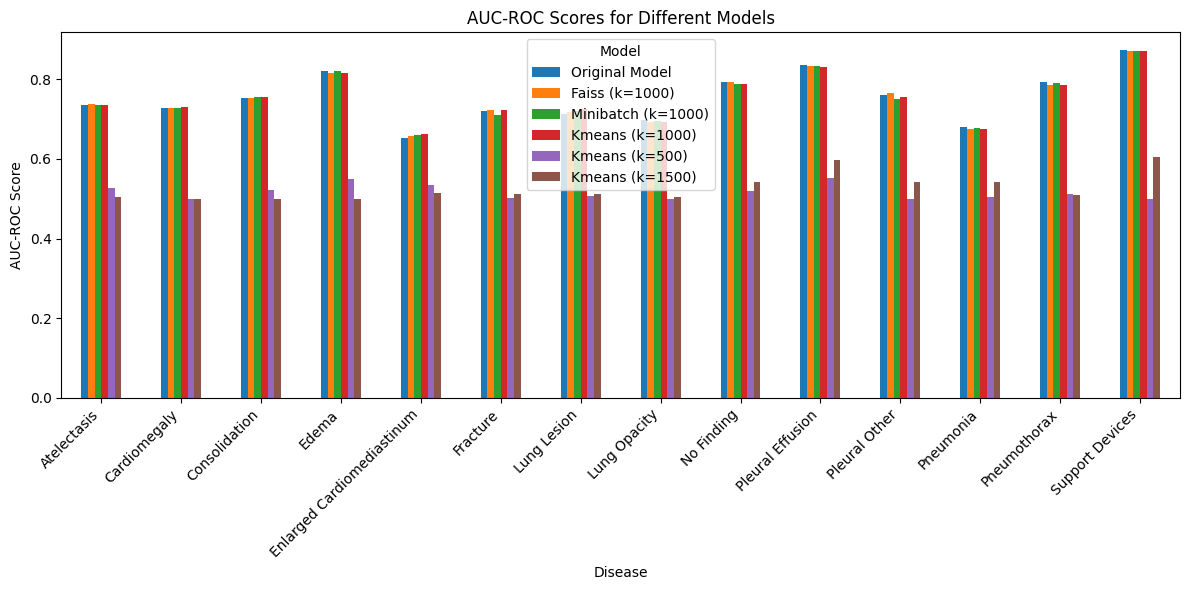

In [53]:

import matplotlib.pyplot as plt
import pandas as pd

def plot_auc_roc(original_df, faiss_df, minibatch_df, kmeans_df, kmean_500_df, kmeans_1500_df,  disease_cols):

    # Extract AUC-ROC values for each model and disease.
    original_auc = original_df.set_index('Disease')['AUC-ROC'].rename("Original Model")
    faiss_auc = faiss_df.set_index('Disease')['AUC-ROC'].rename("Faiss (k=1000)")
    minibatch_auc = minibatch_df.set_index('Disease')['AUC-ROC'].rename("Minibatch (k=1000)")

    kmeans_auc = kmeans_df.set_index('Disease')['AUC-ROC'].rename("Kmeans (k=1000)")
    kmean_500_auc = kmean_500_df.set_index('Disease')['AUC-ROC'].rename("Kmeans (k=500)")
    kmeans_1500_auc = kmeans_1500_df.set_index('Disease')['AUC-ROC'].rename("Kmeans (k=1500)")

    combined_auc = pd.concat([original_auc, faiss_auc, minibatch_auc, kmeans_auc, kmean_500_auc, kmeans_1500_auc], axis=1)

    # Plotting
    plt.figure(figsize=(12, 6))
    combined_auc.plot(kind='bar', figsize=(12,6))
    plt.title('AUC-ROC Scores for Different Models')
    plt.xlabel('Disease')
    plt.ylabel('AUC-ROC Score')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.legend(title='Model')
    plt.show()

original_model_auc_df = calculate_roc_auc(original_model_predictions, disease_cols)
faiss_dedup_auc_df = calculate_roc_auc(faiss_dedup_model_prediction, disease_cols)
kmeans_1000_dedup_auc_df = calculate_roc_auc(kmeans_1000_dedup_model_prediction, disease_cols)
minibatch_dedup_auc_df = calculate_roc_auc(minibatch_dedup_model_prediction, disease_cols)
kmean_500_auc = calculate_roc_auc(kmeans_500_dedup_model_prediction, disease_cols)
print(kmean_500_auc)
kmeans_1500_auc = calculate_roc_auc(kmeans_1500_dedup_model_prediction, disease_cols)


plot_auc_roc(original_model_auc_df, faiss_dedup_auc_df, minibatch_dedup_auc_df,  kmeans_1000_dedup_auc_df, kmean_500_auc, kmeans_1500_auc, disease_cols)


## Calculate underDiagnosation (NoFinding FPR)

In [11]:
FPRs = {}
FPRs['faiss'] = {}
FPRs['kmeans'] = {}
FPRs['minibatch'] = {}
FPRs['original'] = {}
FPRs['kmeans_500'] = {}
FPRs['kmeans_1500'] = {}
for subgroup in faissDataMetrics.keys():
  for metric in faissDataMetrics[subgroup]['FPR'].keys():
    FPRs['faiss'][metric] = faissDataMetrics[subgroup]['FPR'][metric]['No Finding']
    FPRs['kmeans'][metric] = kmeansDataMetrics[subgroup]['FPR'][metric]['No Finding']
    FPRs['minibatch'][metric] = minibatchDataMetrics[subgroup]['FPR'][metric]['No Finding']
    FPRs['original'][metric] = originalDataMetrics[subgroup]['FPR'][metric]['No Finding']
    FPRs['kmeans_500'][metric] = kmeansDataMetrics[subgroup]['FPR'][metric]['No Finding']
    FPRs['kmeans_1500'][metric] = kmeansDataMetrics[subgroup]['FPR'][metric]['No Finding']

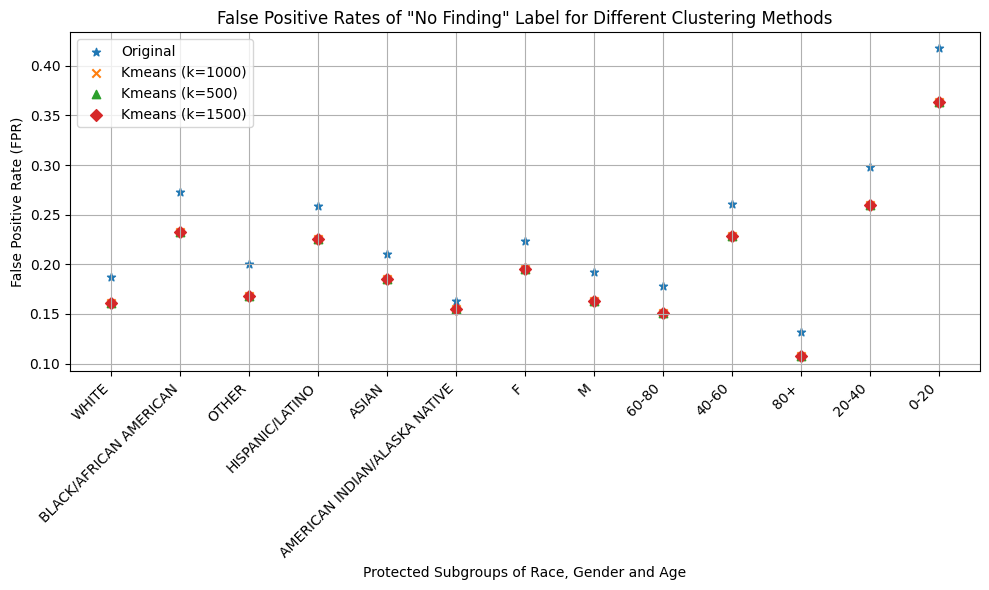

In [42]:

import pickle
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Plotting FPRs for each method
plt.scatter(list(FPRs['original'].keys()), list(FPRs['original'].values()), marker='*', label='Original')
plt.scatter(list(FPRs['kmeans'].keys()), list(FPRs['kmeans'].values()), marker='x', label='Kmeans (k=1000)')

plt.scatter(list(FPRs['kmeans_500'].keys()), list(FPRs['kmeans_500'].values()), marker='^', label='Kmeans (k=500)')
plt.scatter(list(FPRs['kmeans_1500'].keys()), list(FPRs['kmeans_1500'].values()), marker='D', label='Kmeans (k=1500)')

plt.xlabel("Protected Subgroups of Race, Gender and Age")
plt.ylabel("False Positive Rate (FPR)")
plt.title("False Positive Rates of \"No Finding\" Label for Different Clustering Methods")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()


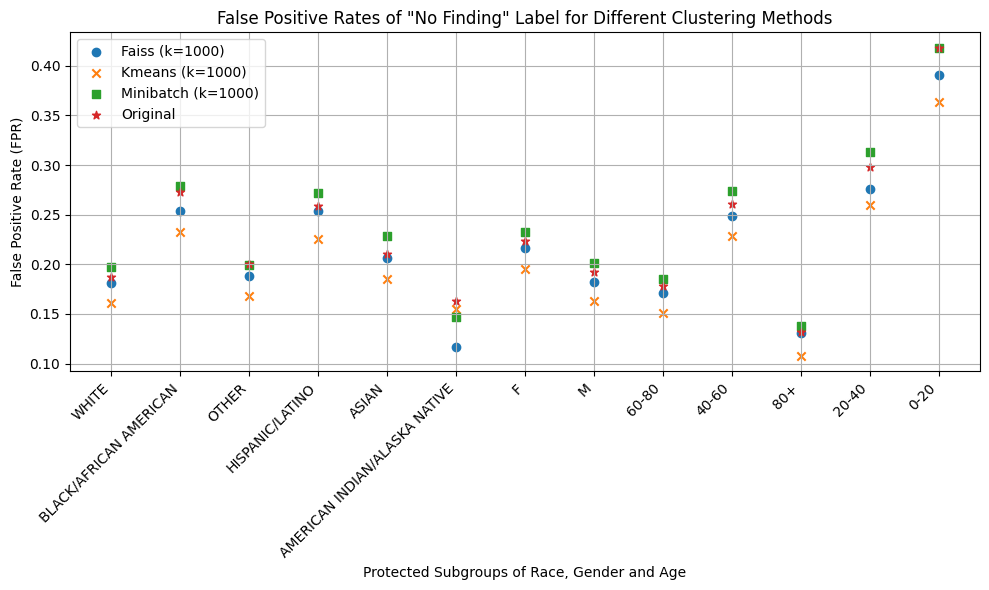

In [52]:
import pickle
from matplotlib import pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))

# Plotting FPRs for each method
plt.scatter(list(FPRs['faiss'].keys()), list(FPRs['faiss'].values()), marker='o', label='Faiss (k=1000)')
plt.scatter(list(FPRs['kmeans'].keys()), list(FPRs['kmeans'].values()), marker='x', label='Kmeans (k=1000)')
plt.scatter(list(FPRs['minibatch'].keys()), list(FPRs['minibatch'].values()), marker='s', label='Minibatch (k=1000)')
plt.scatter(list(FPRs['original'].keys()), list(FPRs['original'].values()), marker='*', label='Original')
# Customize the plot
plt.xlabel("Protected Subgroups of Race, Gender and Age")
plt.ylabel("False Positive Rate (FPR)")
plt.title("False Positive Rates of \"No Finding\" Label for Different Clustering Methods")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

In [13]:
def calcluate_overall_tpr(df_disease, labels, pred_prefix):
  TPR_per_disease = {}
  for disease in labels:
    predicted_disease_name = pred_prefix + str(disease)
    TPR = calculate_tpr(df_disease, predicted_disease_name, disease)
    TPR_per_disease[disease] = TPR
  return TPR_per_disease


def calcluate_overall_fpr(df_disease, labels, pred_prefix):
  FPR_per_disease = {}
  for disease in labels:
    predicted_disease_name = pred_prefix + str(disease)
    FPR = calculate_fpr(df_disease, predicted_disease_name, disease)
    FPR_per_disease[disease] = FPR
  return FPR_per_disease

In [14]:
faiss_tprs_overall = calcluate_overall_tpr(faiss_dedup_model_prediction, labels, pred_prefix)
kmeans_tprs_overall = calcluate_overall_tpr(kmeans_1000_dedup_model_prediction, labels, pred_prefix)
minibatch_tprs_overall = calcluate_overall_tpr(minibatch_dedup_model_prediction, labels, pred_prefix)
original_tprs_overall = calcluate_overall_tpr(original_model_predictions, labels, pred_prefix)
kmeans_500_tprs_overall = calcluate_overall_tpr(kmeans_500_dedup_model_prediction, labels, pred_prefix)
kmeans_1500_tprs_overall = calcluate_overall_tpr(kmeans_1500_dedup_model_prediction, labels, pred_prefix)


## calculate TPR gaps

### Gender

In [15]:
TPR_gaps_per_disease_race = {
    'faiss': {},
    'kmeans': {},
    'minibatch': {},
    'original': {},
    'kmeans_500': {},
    'kmeans_1500': {},
    }
TPR_gaps_per_disease_gender = {
    'faiss': {},
    'kmeans': {},
    'minibatch': {},
    'original': {},
    'kmeans_500': {},
    'kmeans_1500': {},
    }

for metric in faissDataMetrics['gender']['TPR'].keys():
    # Initialize metric as an empty dictionary for each method
    TPR_gaps_per_disease_gender['faiss'][metric] = {}
    TPR_gaps_per_disease_gender['kmeans'][metric] = {}
    TPR_gaps_per_disease_gender['minibatch'][metric] = {}
    TPR_gaps_per_disease_gender['original'][metric] = {}
    TPR_gaps_per_disease_gender['kmeans_500'][metric] = {}
    TPR_gaps_per_disease_gender['kmeans_1500'][metric] = {}

    for disease in faissDataMetrics['gender']['TPR'][metric].keys():
        TPR_gaps_per_disease_gender['faiss'][metric][disease] = (
            faissDataMetrics['gender']['TPR'][metric][disease] - faiss_tprs_overall[disease]
        )
        TPR_gaps_per_disease_gender['kmeans'][metric][disease] = (
            kmeansDataMetrics['gender']['TPR'][metric][disease] - kmeans_tprs_overall[disease]
        )
        TPR_gaps_per_disease_gender['minibatch'][metric][disease] = (
            minibatchDataMetrics['gender']['TPR'][metric][disease] - minibatch_tprs_overall[disease]
        )
        TPR_gaps_per_disease_gender['original'][metric][disease] = (
            originalDataMetrics['gender']['TPR'][metric][disease] - original_tprs_overall[disease]
        )
        TPR_gaps_per_disease_gender['kmeans_500'][metric][disease] = (
            kmeans_500_DataMetrics['gender']['TPR'][metric][disease] - original_tprs_overall[disease]
        )
        TPR_gaps_per_disease_gender['kmeans_1500'][metric][disease] = (
            kmeans_1500_DataMetrics['gender']['TPR'][metric][disease] - original_tprs_overall[disease]
        )




### Race

In [16]:
for metric in faissDataMetrics['race']['TPR'].keys():
    # Initialize metric as an empty dictionary for each method
    TPR_gaps_per_disease_race['faiss'][metric] = {}
    TPR_gaps_per_disease_race['kmeans'][metric] = {}
    TPR_gaps_per_disease_race['minibatch'][metric] = {}
    TPR_gaps_per_disease_race['original'][metric] = {}
    TPR_gaps_per_disease_race['kmeans_500'][metric] = {}
    TPR_gaps_per_disease_race['kmeans_1500'][metric] = {}

    for disease in faissDataMetrics['race']['TPR'][metric].keys():
        TPR_gaps_per_disease_race['faiss'][metric][disease] = (
            faissDataMetrics['race']['TPR'][metric][disease] - faiss_tprs_overall[disease]
        )
        TPR_gaps_per_disease_race['kmeans'][metric][disease] = (
            kmeansDataMetrics['race']['TPR'][metric][disease] - kmeans_tprs_overall[disease]
        )
        TPR_gaps_per_disease_race['minibatch'][metric][disease] = (
            minibatchDataMetrics['race']['TPR'][metric][disease] - minibatch_tprs_overall[disease]
        )
        TPR_gaps_per_disease_race['original'][metric][disease] = (
            originalDataMetrics['race']['TPR'][metric][disease] - original_tprs_overall[disease]
        )
        TPR_gaps_per_disease_race['kmeans_500'][metric][disease] = (
            kmeans_500_DataMetrics['race']['TPR'][metric][disease] - original_tprs_overall[disease]
        )
        TPR_gaps_per_disease_race['kmeans_1500'][metric][disease] = (
            kmeans_1500_DataMetrics['race']['TPR'][metric][disease] - original_tprs_overall[disease]
        )


In [17]:
# prompt: this code but instead of race, for age_decile

# Assuming the provided code is already executed and the necessary variables are defined

# Calculate TPR gaps for age_decile
TPR_gaps_per_disease_age = {
    'faiss': {},
    'kmeans': {},
    'minibatch': {},
    'original': {},
    'kmeans_1500': {},
    'kmeans_500': {},

}

for metric in faissDataMetrics['age']['TPR'].keys():
    TPR_gaps_per_disease_age['faiss'][metric] = {}
    TPR_gaps_per_disease_age['kmeans'][metric] = {}
    TPR_gaps_per_disease_age['minibatch'][metric] = {}
    TPR_gaps_per_disease_age['original'][metric] = {}
    TPR_gaps_per_disease_age['kmeans_1500'][metric] = {}
    TPR_gaps_per_disease_age['kmeans_500'][metric] = {}


    for disease in faissDataMetrics['age']['TPR'][metric].keys():
        TPR_gaps_per_disease_age['faiss'][metric][disease] = (
            faissDataMetrics['age']['TPR'][metric][disease] - faiss_tprs_overall[disease]
        )
        TPR_gaps_per_disease_age['kmeans'][metric][disease] = (
            kmeansDataMetrics['age']['TPR'][metric][disease] - kmeans_tprs_overall[disease]
        )
        TPR_gaps_per_disease_age['minibatch'][metric][disease] = (
            minibatchDataMetrics['age']['TPR'][metric][disease] - minibatch_tprs_overall[disease]
        )
        TPR_gaps_per_disease_age['original'][metric][disease] = (
            originalDataMetrics['age']['TPR'][metric][disease] - original_tprs_overall[disease]
        )
        TPR_gaps_per_disease_age['kmeans_1500'][metric][disease] = (
            kmeans_1500_DataMetrics['age']['TPR'][metric][disease] - kmeans_tprs_overall[disease]
        )
        TPR_gaps_per_disease_age['kmeans_500'][metric][disease] = (
        kmeans_500_DataMetrics['age']['TPR'][metric][disease] - kmeans_tprs_overall[disease]
        )




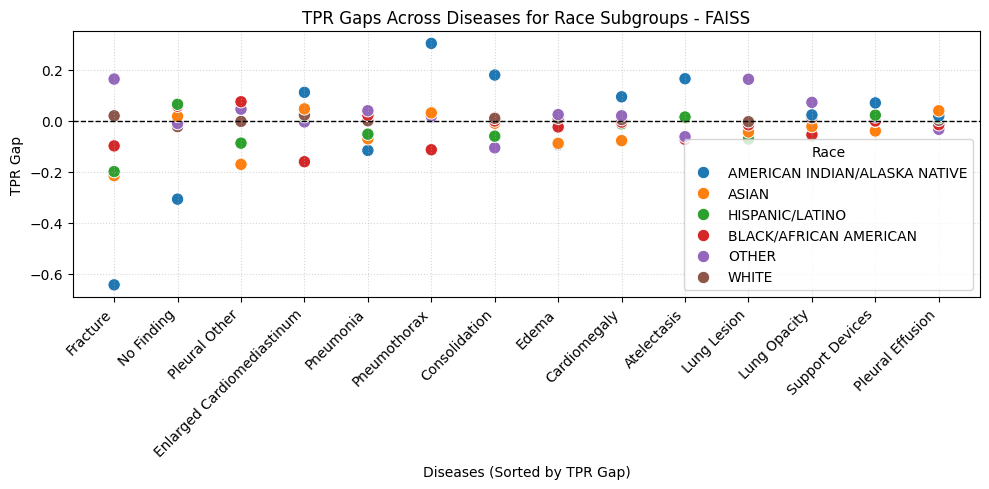

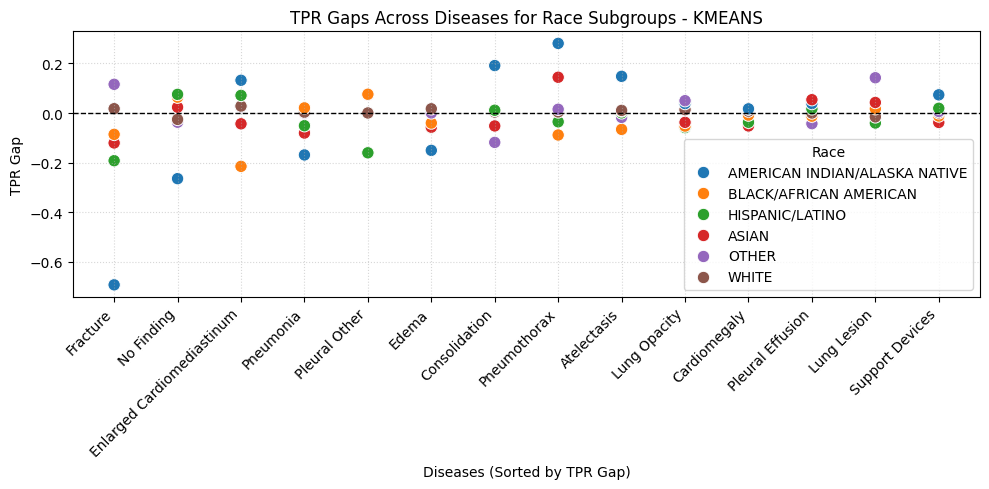

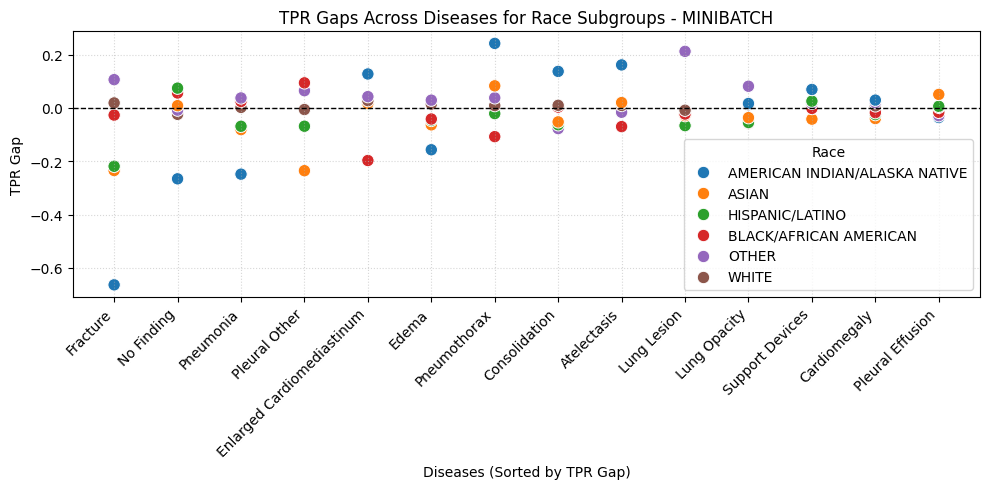

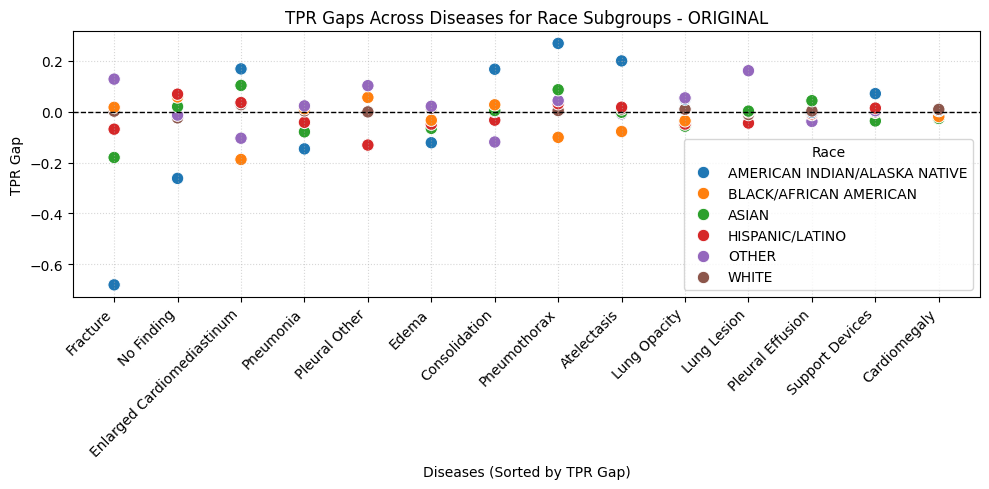

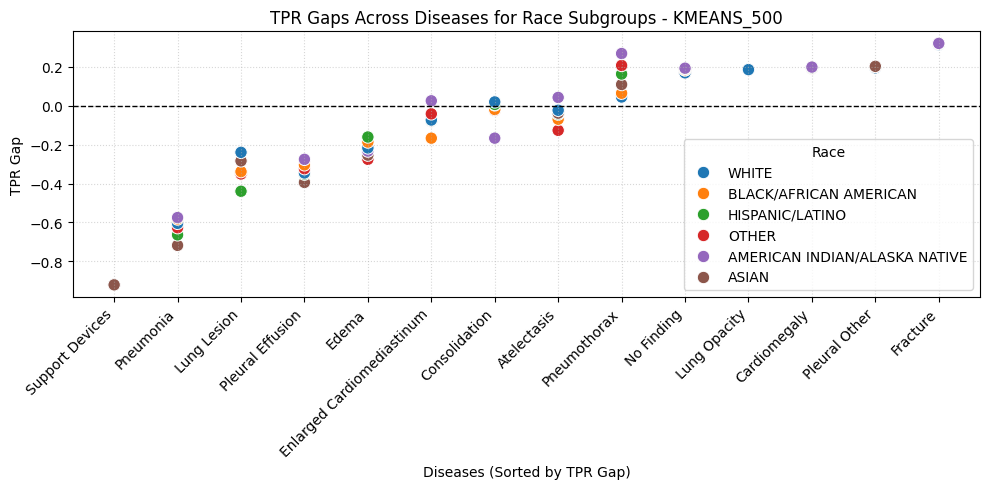

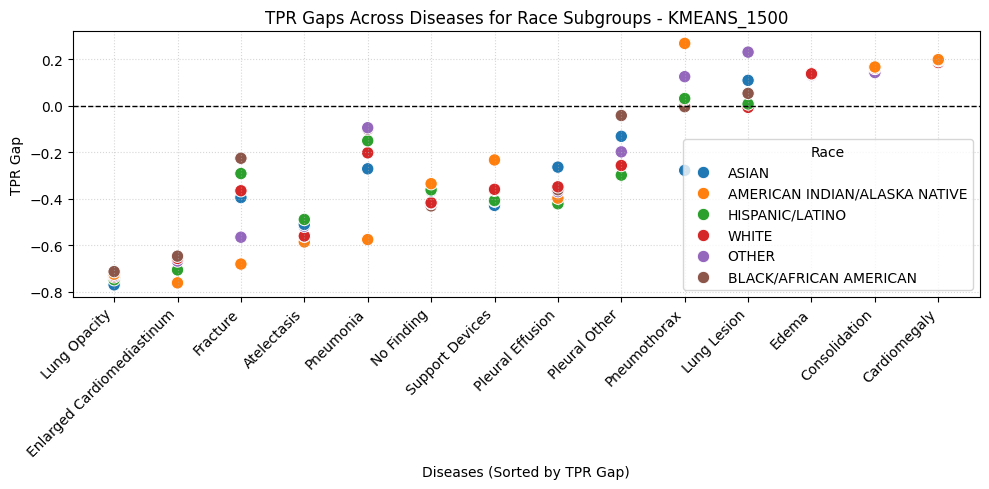

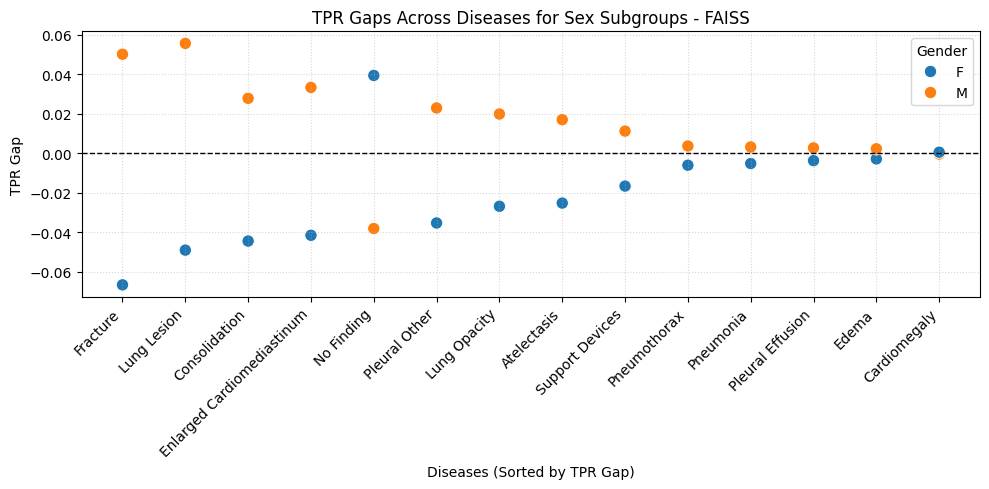

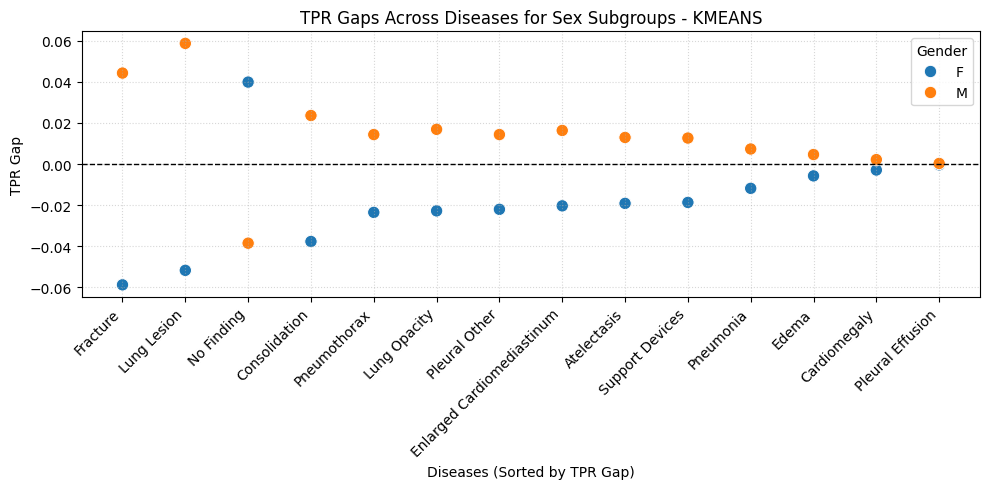

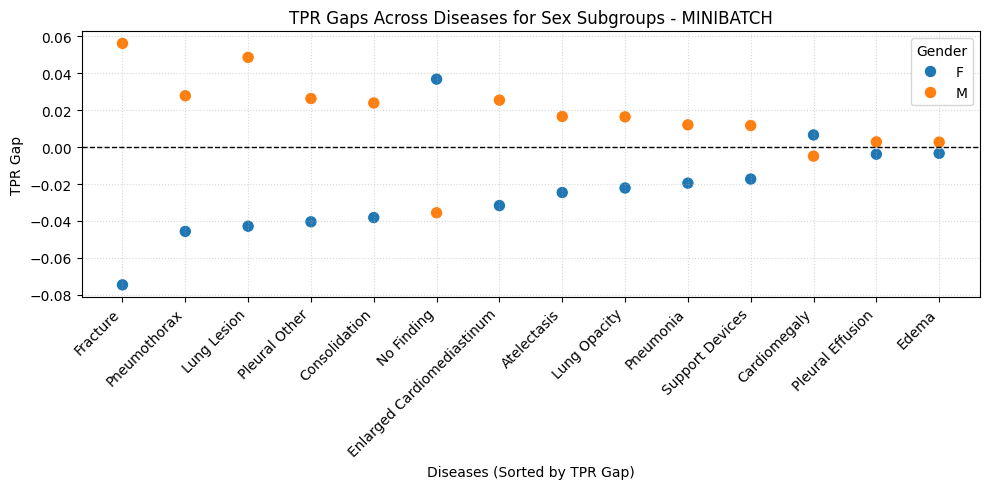

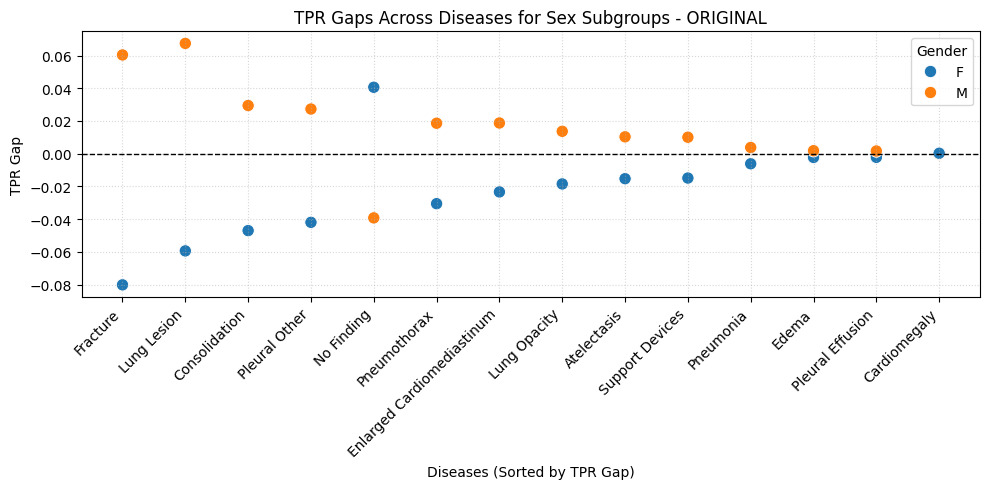

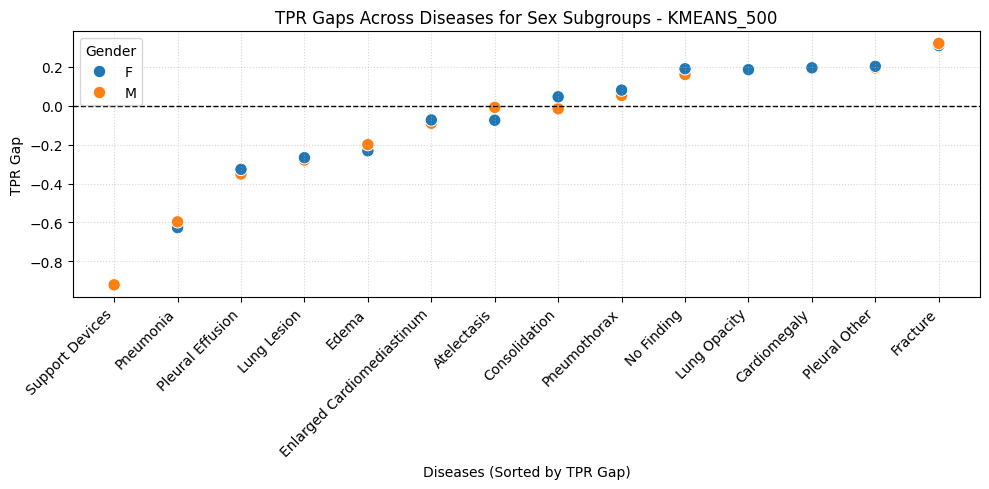

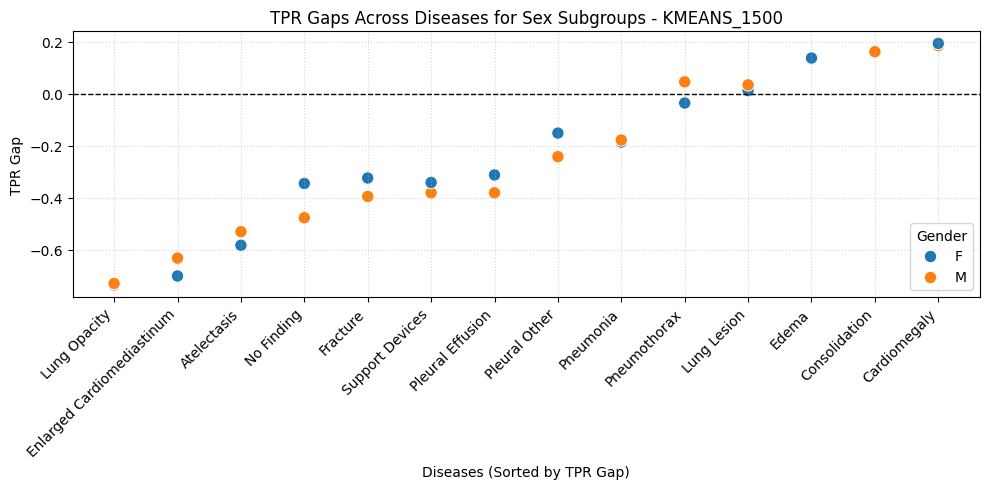

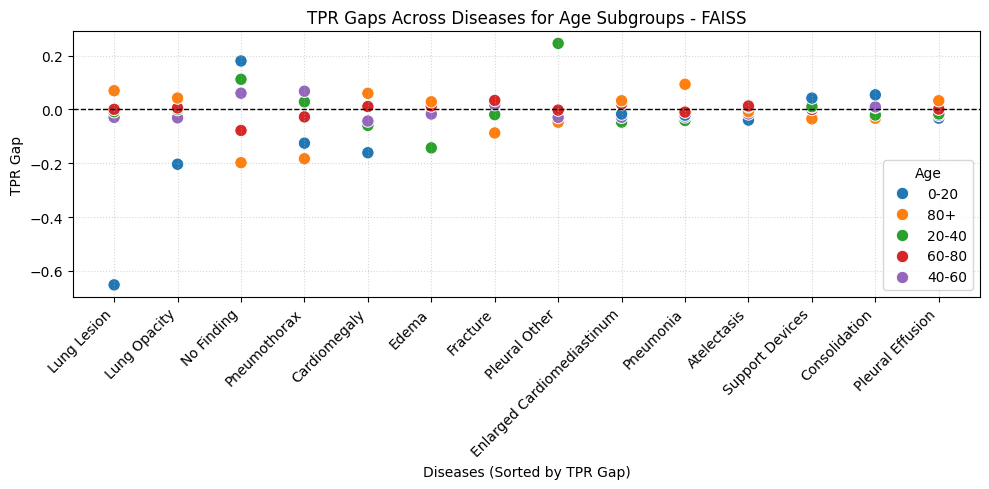

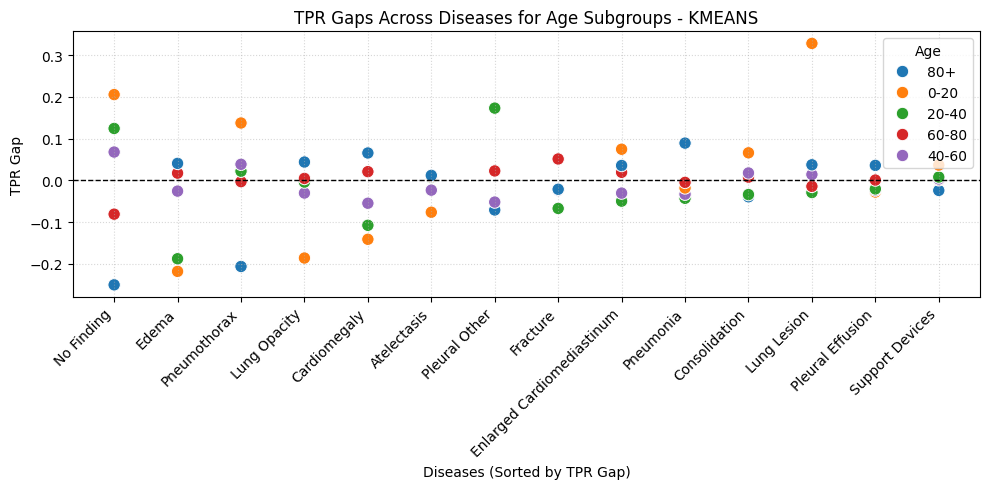

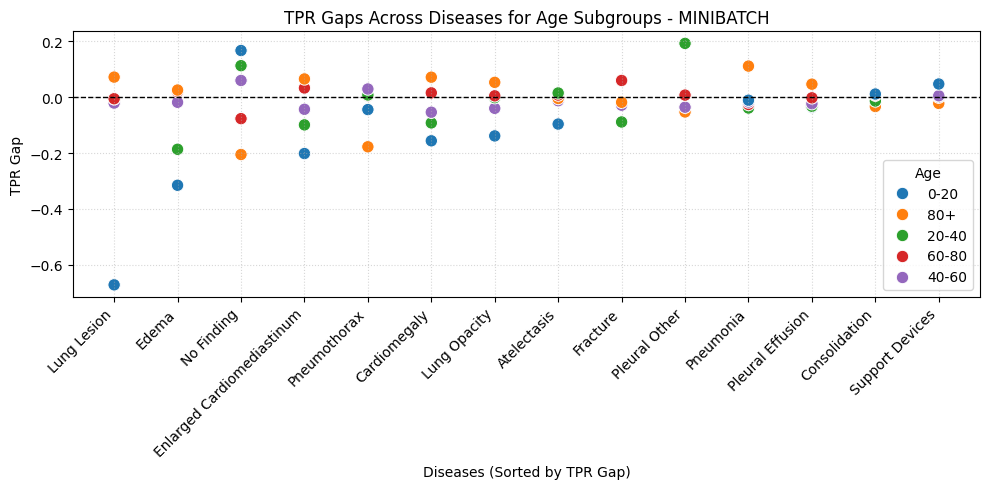

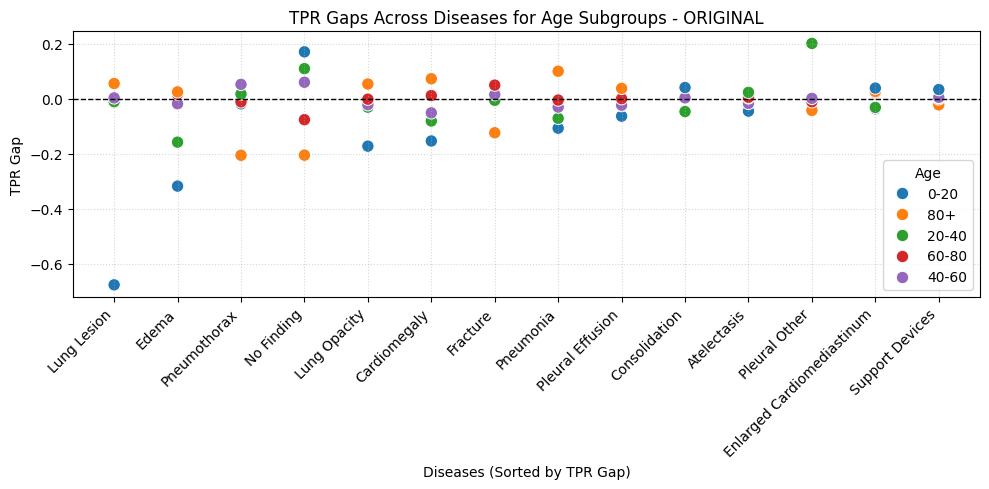

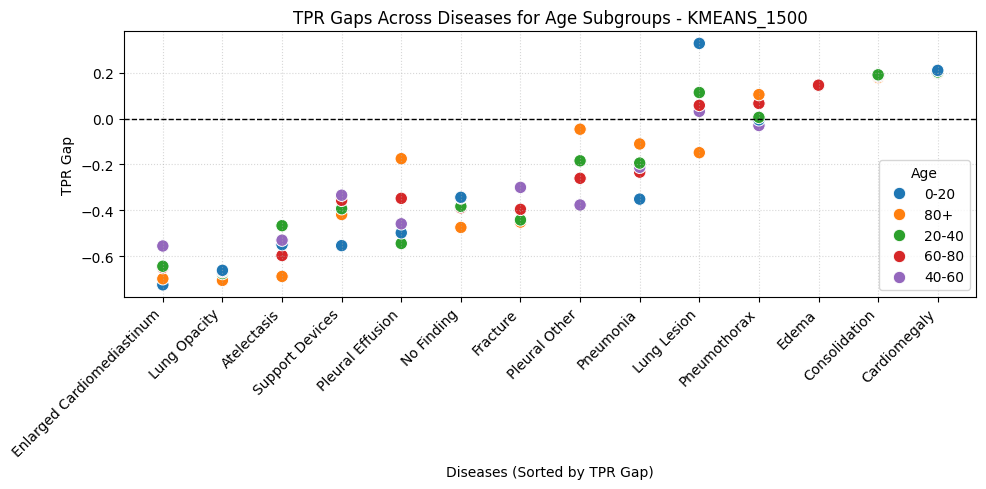

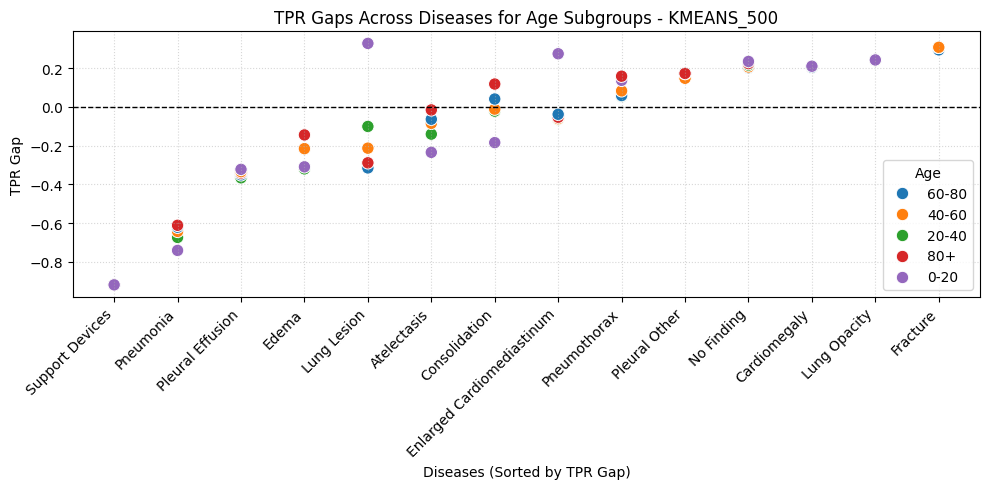

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_tpr_gaps_scatter(TPR_gaps, title, demographic_type):
    for method in TPR_gaps.keys():  # Loop through each method
        plt.figure(figsize=(10, 5))

        # Convert dictionary to DataFrame
        data = []
        for group, diseases in TPR_gaps[method].items():
            for disease, gap in diseases.items():
                data.append({
                    'Disease': disease,
                    'TPR Gap': gap,
                    demographic_type: group  # 'Race' or 'Gender'
                })

        df = pd.DataFrame(data)

        # Sort diseases for consistent x-axis
        df = df.sort_values(by="TPR Gap")

        # Scatter plot
        sns.scatterplot(x="Disease", y="TPR Gap", hue=demographic_type, data=df, s=80)

        # Formatting
        plt.xticks(rotation=45, ha='right')
        plt.axhline(0, color='black', linewidth=1, linestyle='dashed')  # Baseline at zero
        plt.title(f"{title} - {method.upper()}")
        plt.ylabel("TPR Gap")
        plt.xlabel("Diseases (Sorted by TPR Gap)")
        plt.legend(title=demographic_type)
        plt.grid(True, linestyle="dotted", alpha=0.5)
        plt.tight_layout()

        # Show plot
        plt.show()

# Generate plots
plot_tpr_gaps_scatter(TPR_gaps_per_disease_race, "TPR Gaps Across Diseases for Race Subgroups", "Race")
plot_tpr_gaps_scatter(TPR_gaps_per_disease_gender, "TPR Gaps Across Diseases for Sex Subgroups", "Gender")
plot_tpr_gaps_scatter(TPR_gaps_per_disease_age, "TPR Gaps Across Diseases for Age Subgroups", "Age")


In [19]:
# Helper function to get the favorable subgroup for each disease
def get_favorable_subgroup(tprs):
  groups = list(tprs.keys())
  favorbale_subgroups = {}
  favorable_subgroup_counts = {}
  for disease in tprs[groups[0]]:
    tpr_values = {group: tprs[group][disease] for group in tprs}
    favorable = max(tpr_values, key=tpr_values.get)
    favorbale_subgroups[disease] = favorable
    favorable_subgroup_counts[favorable] = favorable_subgroup_counts.get(favorable, 0) + 1

  favorable_subgroup_over_all = max(favorable_subgroup_counts, key=favorable_subgroup_counts.get)
  return favorbale_subgroups, favorable_subgroup_over_all


In [20]:

def get_less_favorable_subgroup(tprs):
  groups = list(tprs.keys())
  less_favorbale_subgroups = {}
  less_favorable_subgroup_counts = {}
  for disease in tprs[groups[0]]:
    tpr_values = {group: tprs[group][disease] for group in tprs}
    less_favorable = min(tpr_values, key=tpr_values.get)
    less_favorbale_subgroups[disease] = less_favorable
    less_favorable_subgroup_counts[less_favorable] = less_favorable_subgroup_counts.get(less_favorable, 0) + 1

  less_favorable_subgroup_over_all = max(less_favorable_subgroup_counts, key=less_favorable_subgroup_counts.get)
  return less_favorbale_subgroups, less_favorable_subgroup_over_all


In [21]:
def calculate_disease_disparities(tpr_gaps):
  disease_disparities = {}

  for disease, subgroup_gaps in tpr_gaps.items():
      subgroup_disparities = {}
      print(subgroup_gaps)

      for subgroup, gaps in subgroup_gaps.items():
          max_gap = max(gaps.values())
          min_gap = min(gaps.values())
          disparity = max_gap - min_gap
          subgroup_disparities[subgroup] = disparity

      disease_disparities[disease] = subgroup_disparities

  return disease_disparities

In [22]:
def calculate_distance(TPR_gap_per_subgroup):

  distances = {}
  groups = list(TPR_gap_per_subgroup.keys())
  for disease in TPR_gap_per_subgroup[groups[0]].keys():
      tpr_values = [TPR_gap_per_subgroup[group][disease] for group in groups]
      most_positive = max(tpr_values)
      least_negative = min(tpr_values)
      distance = most_positive - least_negative
      distances[disease] = distance

  return distances

## Max distance for each method

In [23]:
methods = ['faiss', 'kmeans', 'minibatch', 'original']

In [24]:
print("Max distances for age:")
for m in methods:
  print("Max distance for method ", m)
  distances = calculate_distance(TPR_gaps_per_disease_age[m])
  max_value = max(distances.values())
  max_key = [k for k, v in distances.items() if v == max_value][0]
  print(max_key, max_value)


Max distances for age:
Max distance for method  faiss
Lung Lesion 0.7209302325581395
Max distance for method  kmeans
No Finding 0.45559400230680513
Max distance for method  minibatch
Lung Lesion 0.7441860465116279
Max distance for method  original
Lung Lesion 0.7325581395348837


In [25]:
print("Max distances for gender")
for m in methods:
  print("Max distance for method ", m)
  distances = calculate_distance(TPR_gaps_per_disease_gender[m])
  max_value = max(distances.values())
  max_key = [k for k, v in distances.items() if v == max_value][0]
  print(max_key, max_value)

Max distances for gender
Max distance for method  faiss
Fracture 0.11678289167828926
Max distance for method  kmeans
Lung Lesion 0.11046168909670395
Max distance for method  minibatch
Fracture 0.13077638307763828
Max distance for method  original
Fracture 0.14058577405857742


In [26]:
print("Max distances for race")
for m in methods:
  print("Max distance for method ", m)
  distances = calculate_distance(TPR_gaps_per_disease_race[m])
  max_value = max(distances.values())
  max_key = [k for k, v in distances.items() if v == max_value][0]
  print(max_key, max_value)

Max distances for race
Max distance for method  faiss
Fracture 0.8076923076923077
Max distance for method  kmeans
Fracture 0.8076923076923077
Max distance for method  minibatch
Fracture 0.7692307692307693
Max distance for method  original
Fracture 0.8076923076923077


## Average distance for each method

In [27]:
print("avegrage distance for age:")
for m in methods:
  print("Average distance for method ", m)
  distances = calculate_distance(TPR_gaps_per_disease_age[m])
  average_value = sum(distances.values()) / len(distances)
  print(average_value)

avegrage distance for age:
Average distance for method  faiss
0.20690297086933498
Average distance for method  kmeans
0.19917083198516553
Average distance for method  minibatch
0.22887515370162367
Average distance for method  original
0.22675958733493515


In [28]:
print("avegrage distance for gender:")
for m in methods:
  print("Average distance for method ", m)
  distances = calculate_distance(TPR_gaps_per_disease_gender[m])
  average_value = sum(distances.values()) / len(distances)
  print(average_value)

avegrage distance for gender:
Average distance for method  faiss
0.04656641898195312
Average distance for method  kmeans
0.043042561311817204
Average distance for method  minibatch
0.051331051850377216
Average distance for method  original
0.04897663759368751


In [29]:
print("avegrage distance for race:")
for m in methods:
  print("Average distance for method ", m)
  distances = calculate_distance(TPR_gaps_per_disease_race[m])
  average_value = sum(distances.values()) / len(distances)
  print(average_value)

avegrage distance for race:
Average distance for method  faiss
0.2596681659630701
Average distance for method  kmeans
0.253318613713365
Average distance for method  minibatch
0.26520866923926445
Average distance for method  original
0.25087550812632464


## Distances for age

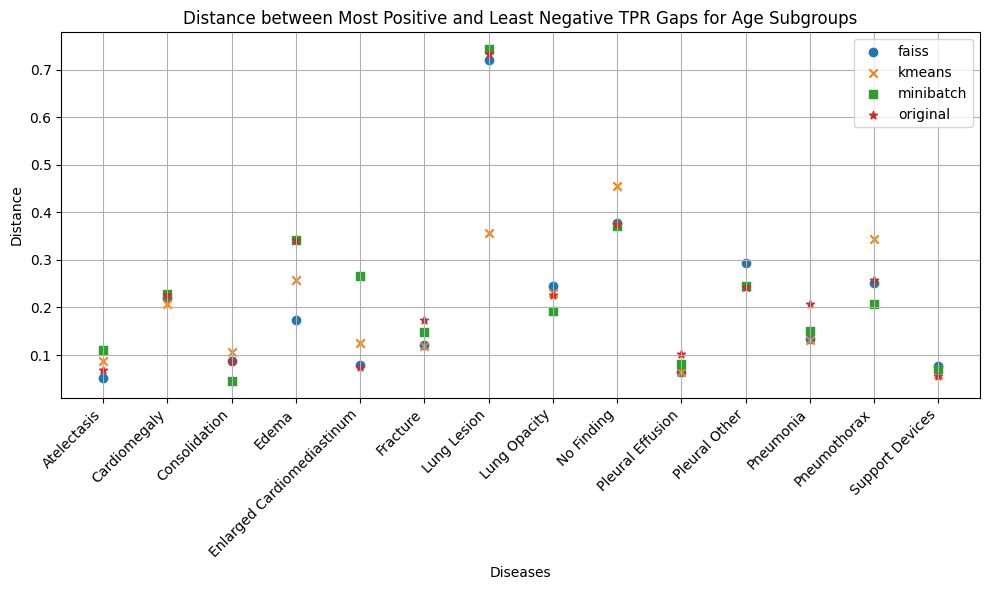

In [30]:
import matplotlib.pyplot as plt

markers = ['o', 'x', 's', '*']  # Define markers for each method
methods = ['faiss', 'kmeans', 'minibatch', 'original']

plt.figure(figsize=(10, 6))

for i, m in enumerate(methods):
    distances = calculate_distance(TPR_gaps_per_disease_age[m])
    plt.scatter(distances.keys(), distances.values(), marker=markers[i], label=m)

plt.xlabel("Diseases")
plt.ylabel("Distance")
plt.title("Distance between Most Positive and Least Negative TPR Gaps for Age Subgroups")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


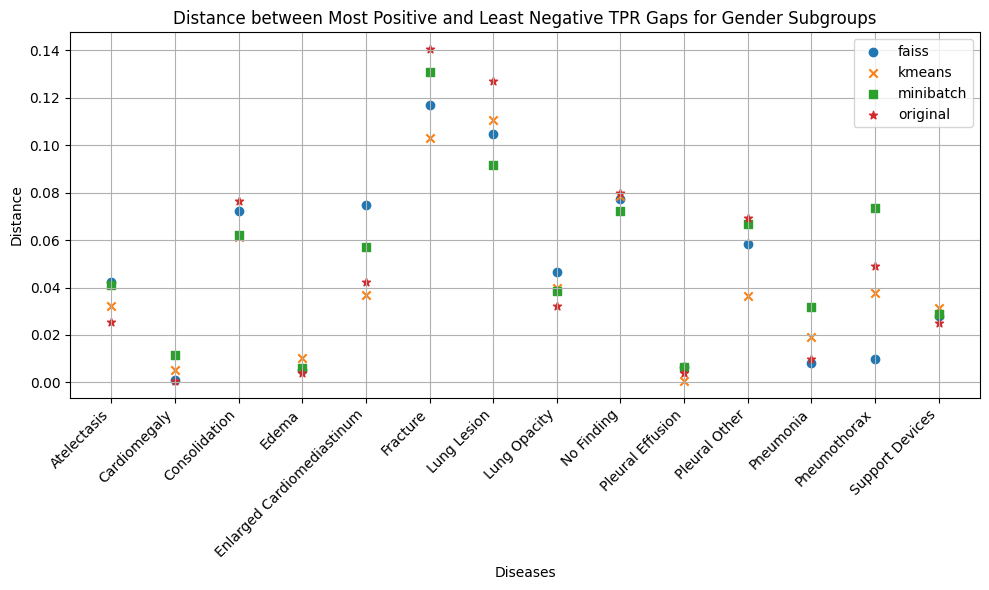

In [31]:
import matplotlib.pyplot as plt

markers = ['o', 'x', 's', '*']  # Define markers for each method
methods = ['faiss', 'kmeans', 'minibatch', 'original']

plt.figure(figsize=(10, 6))

for i, m in enumerate(methods):
    distances = calculate_distance(TPR_gaps_per_disease_gender[m])
    plt.scatter(distances.keys(), distances.values(), marker=markers[i], label=m)

plt.xlabel("Diseases")
plt.ylabel("Distance")
plt.title("Distance between Most Positive and Least Negative TPR Gaps for Gender Subgroups")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


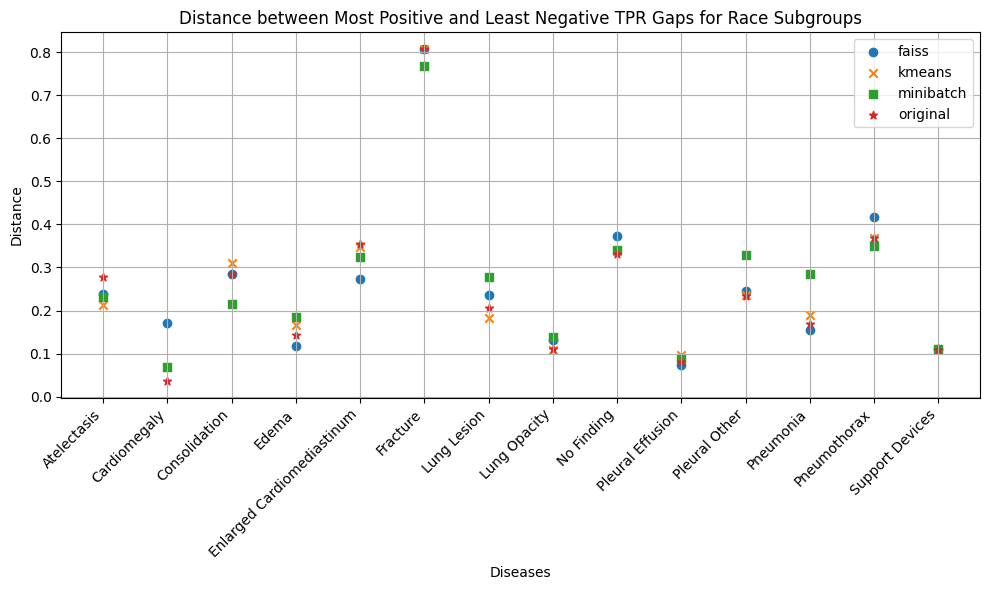

In [32]:
import matplotlib.pyplot as plt

markers = ['o', 'x', 's', '*']  # Define markers for each method
methods = ['faiss', 'kmeans', 'minibatch', 'original']

plt.figure(figsize=(10, 6))

for i, m in enumerate(methods):
    distances = calculate_distance(TPR_gaps_per_disease_race[m])
    plt.scatter(distances.keys(), distances.values(), marker=markers[i], label=m)

plt.xlabel("Diseases")
plt.ylabel("Distance")
plt.title("Distance between Most Positive and Least Negative TPR Gaps for Race Subgroups")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

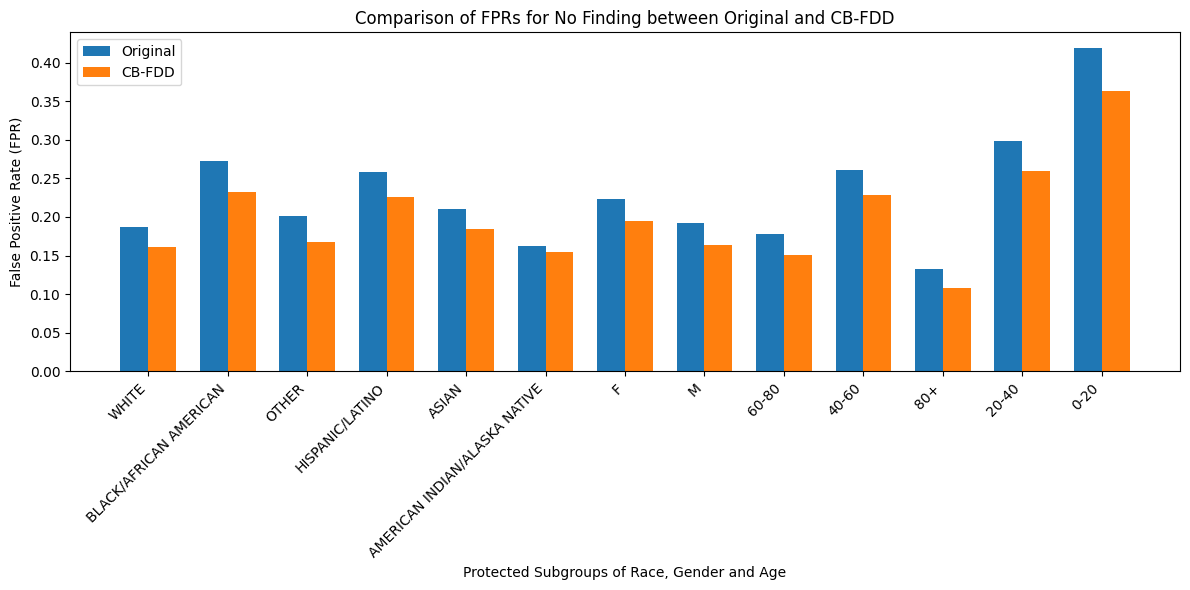

In [51]:
# prompt: plot all fprs for original and kmeans models. do it bar model

import matplotlib.pyplot as plt

# Assuming FPRs dictionary is already populated as in the provided code

# Prepare data for the bar plot
categories = list(FPRs['original'].keys())  # Use original model keys for categories
original_fprs = list(FPRs['original'].values())
kmeans_fprs = list(FPRs['kmeans'].values())

# Create the bar plot
bar_width = 0.35
index = range(len(categories))

fig, ax = plt.subplots(figsize=(12, 6))
original_bars = ax.bar(index, original_fprs, bar_width, label='Original')
kmeans_bars = ax.bar([i + bar_width for i in index], kmeans_fprs, bar_width, label='CB-FDD')

# Add labels and title
ax.set_xlabel('Protected Subgroups of Race, Gender and Age')
ax.set_ylabel('False Positive Rate (FPR)')
ax.set_title('Comparison of FPRs for No Finding between Original and CB-FDD')
ax.set_xticks([i + bar_width / 2 for i in index])  # Center x-axis ticks
ax.set_xticklabels(categories, rotation=45, ha='right')  # Rotate labels
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [34]:
fave_gender_og = get_favorable_subgroup(originalDataMetrics['gender']['TPR'])
less_fave_gender_og = get_less_favorable_subgroup(originalDataMetrics['gender']['TPR'])

fave_gander_kmeans = get_favorable_subgroup(kmeansDataMetrics['gender']['TPR'])
less_fave_gender_kmeans = get_less_favorable_subgroup(kmeansDataMetrics['gender']['TPR'])

fave_race_og = get_favorable_subgroup(originalDataMetrics['race']['TPR'])
less_fave_race_og = get_less_favorable_subgroup(originalDataMetrics['race']['TPR'])

fave_race_kmeans = get_favorable_subgroup(kmeansDataMetrics['race']['TPR'])
less_fave_race_kmeans = get_less_favorable_subgroup(kmeansDataMetrics['race']['TPR'])

fave_age_og = get_favorable_subgroup(originalDataMetrics['age']['TPR'])
less_fave_age_og = get_less_favorable_subgroup(originalDataMetrics['age']['TPR'])

fave_age_kmeans = get_favorable_subgroup(kmeansDataMetrics['age']['TPR'])
less_fave_age_kmeans = get_less_favorable_subgroup(kmeansDataMetrics['age']['TPR'])

In [35]:
# prompt: count the number of occurences of different values in a dictionary

from collections import Counter

def count_dict_occurrences(input_dict):
  value_counts = Counter(input_dict.values())
  return dict(value_counts)

fave_counts_og_gender = count_dict_occurrences(fave_gender_og[0])
less_fave_counts_og_gender = count_dict_occurrences(less_fave_gender_og[0])

fave_counts_kmeans_gender = count_dict_occurrences(fave_gander_kmeans[0])
less_fave_counts_kmeans_gender = count_dict_occurrences(less_fave_gender_kmeans[0])

fave_counts_og_race = count_dict_occurrences(fave_race_og[0])
less_fave_counts_og_race = count_dict_occurrences(less_fave_race_og[0])

fave_counts_kmeans_race = count_dict_occurrences(fave_race_kmeans[0])
less_fave_counts_kmeans_race = count_dict_occurrences(less_fave_race_kmeans[0])

fave_counts_og_age = count_dict_occurrences(fave_age_og[0])
less_fave_counts_og_age = count_dict_occurrences(less_fave_age_og[0])

fave_counts_kmeans_age = count_dict_occurrences(fave_age_kmeans[0])
less_fave_counts_kmeans_age = count_dict_occurrences(less_fave_age_kmeans[0])


faves = {
    "fave_counts_og_gender": fave_counts_og_gender,
    "less_fave_counts_og_gender": less_fave_counts_og_gender,
    "fave_counts_kmeans_gender": fave_counts_kmeans_age,
    "less_fave_counts_kmeans_gender": less_fave_counts_kmeans_gender,
    "fave_counts_og_race": fave_counts_og_race,
    "less_fave_counts_og_race": less_fave_counts_og_race,
    "fave_counts_kmeans_race": fave_counts_kmeans_race,
    "less_fave_counts_kmeans_race": less_fave_counts_kmeans_race,
    "fave_counts_og_age": fave_counts_og_age,
}

